### Baseline Text Classification Model for All the News Dataset
Goal: Predict the classification of news articles based on their section labels. For our baseline model, we will start with a dataset of 25K articles distributed across five categories: business, sports, technology, healthcare, and movies.

### Import librarires

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, auc
import spacy
from sklearn.metrics import f1_score

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/curtispond/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/curtispond/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load and inspect the data

We start with a smaller dataset created from ~100k articles. The data has already been preprocessed:
1. Dropped the author and url columns
2. Removed rows where article = NaN
3. Removed rows where section = NaN
4. Normalized section names by combining similar sections (i.e., Tech News into Technology, Health into Healthcare)
5. Reduced dataset to sections with labels: technology, healthcare, business, movies, sports

In [2]:
df = pd.read_csv('./data/all-the-news-25k.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         25000 non-null  object 
 1   year         25000 non-null  int64  
 2   month        25000 non-null  float64
 3   day          25000 non-null  int64  
 4   title        25000 non-null  object 
 5   article      25000 non-null  object 
 6   section      25000 non-null  object 
 7   publication  25000 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 1.5+ MB


In [3]:
# Convert the date column to datetime
df['date'] = pd.to_datetime(df['date'])

In [4]:
df.head()

,date,year,month,day,title,article,section,publication
0,2018-05-02 17:09:00,2018,5.0,2,You Can Trick Your Brain Into Being More Focused,If only every day could be like this. You can’...,healthcare,Vice
1,2019-06-23 00:00:00,2019,6.0,23,Hudson's Bay's chairman's buyout bid pits reta...,(Reuters) - The success of Hudson’s Bay Co Exe...,business,Reuters
2,2018-12-28 00:00:00,2018,12.0,28,Wells Fargo to pay $575 million in settlement ...,NEW YORK (Reuters) - Wells Fargo & Co (WFC.N) ...,business,Reuters
3,2019-05-21 00:00:00,2019,5.0,21,Factbox: Investments by automakers in the U.S....,(Reuters) - Major automakers have announced a ...,business,Reuters
4,2019-02-05 00:00:00,2019,2.0,5,Exclusive: Britain's financial heartland unbow...,LONDON (Reuters) - Britain’s financial service...,business,Reuters


In [5]:
# How many null values are there in each column?
df.isnull().sum()

date           0
year           0
month          0
day            0
title          0
article        0
section        0
publication    0
dtype: int64

<AxesSubplot: title={'center': 'Top 20 Article Sections in 25K Sample'}>

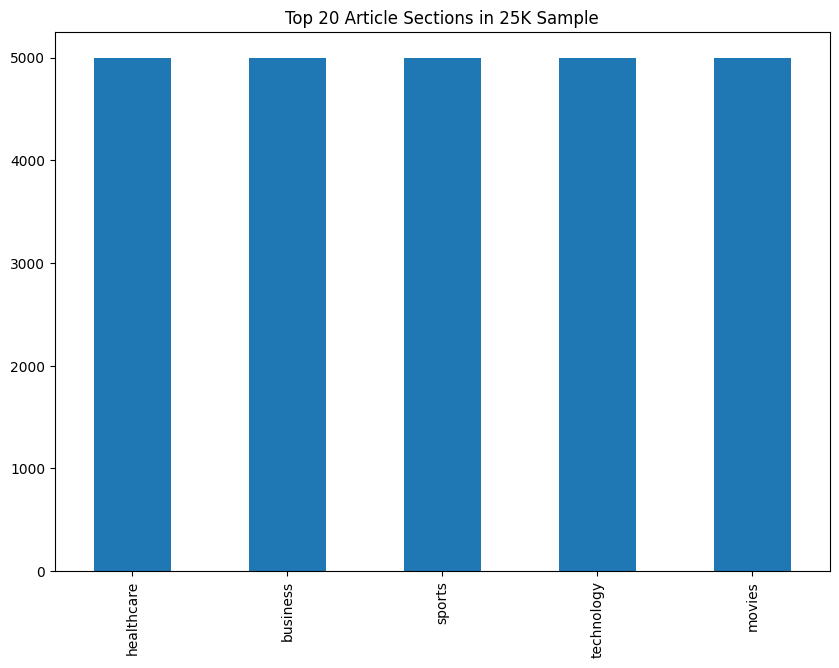

In [6]:
# Show the number of articles in each section
df['section'].value_counts()[:20].plot(kind='bar', figsize=(10,7), title='Top 20 Article Sections in 25K Sample')

### Text Classification process for baseline model

1. Ensure the dataset is as balanced as possible (already done in dataset preparation)
2. Process the data (remove stop words, punctuation, etc.)
3. Create a Bag of Words feature to turn text into numbers
3. Create training and test set
4. Run some models and predictions

### Prepare data for modeling on df dataset

In [7]:
#Convert the section column into categorical values
target_section = df['section'].unique()
print(target_section)

['healthcare' 'business' 'sports' 'technology' 'movies']


In [8]:
# Convert the section column into numerical values
df['sectionId'] = df['section'].factorize()[0]
df.head()

,date,year,month,day,title,article,section,publication,sectionId
0,2018-05-02 17:09:00,2018,5.0,2,You Can Trick Your Brain Into Being More Focused,If only every day could be like this. You can’...,healthcare,Vice,0
1,2019-06-23 00:00:00,2019,6.0,23,Hudson's Bay's chairman's buyout bid pits reta...,(Reuters) - The success of Hudson’s Bay Co Exe...,business,Reuters,1
2,2018-12-28 00:00:00,2018,12.0,28,Wells Fargo to pay $575 million in settlement ...,NEW YORK (Reuters) - Wells Fargo & Co (WFC.N) ...,business,Reuters,1
3,2019-05-21 00:00:00,2019,5.0,21,Factbox: Investments by automakers in the U.S....,(Reuters) - Major automakers have announced a ...,business,Reuters,1
4,2019-02-05 00:00:00,2019,2.0,5,Exclusive: Britain's financial heartland unbow...,LONDON (Reuters) - Britain’s financial service...,business,Reuters,1


In [9]:
# Show the category's name and id
category_id_df = df[['section', 'sectionId']].drop_duplicates().sort_values('sectionId')
category_id_df

,section,sectionId
0,healthcare,0
1,business,1
5,sports,2
11,technology,3
20000,movies,4


<AxesSubplot: title={'center': 'Target Sections and their Corresponding Ids'}, xlabel='section,sectionId'>

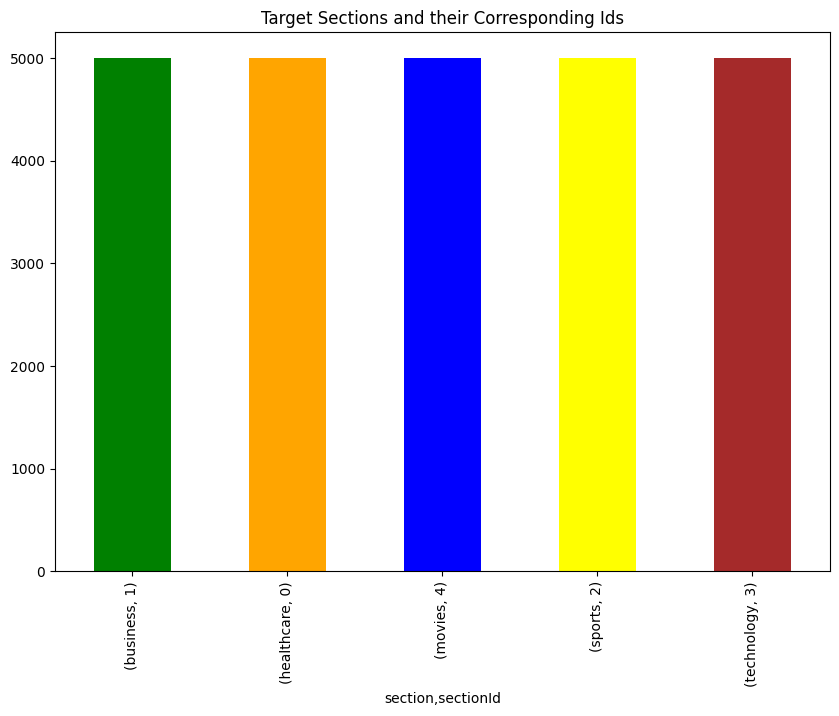

In [10]:
# Visualize the number of articles in each section
df.groupby('section').sectionId.value_counts().plot(kind='bar', \
    color= ["green", "orange", "blue", "yellow", "brown"], figsize=(10,7), title='Target Sections and their Corresponding Ids')

### Clean the article text

In [11]:
# Use NLTK to remove stopwords
stop = stopwords.words('english')

df['clean_article'] = df['article'].map(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [12]:
import re
import string
def process_text(text):
    text = str(text).lower()
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", " ", text
    )
    text = " ".join(text.split())
    return text

df['text'] = df['clean_article'].apply(process_text)

In [13]:
df.head()

,date,year,month,day,title,article,section,publication,sectionId,clean_article,text
0,2018-05-02 17:09:00,2018,5.0,2,You Can Trick Your Brain Into Being More Focused,If only every day could be like this. You can’...,healthcare,Vice,0,If every day could like this. You can’t put fi...,if every day could like this you can’t put fin...
1,2019-06-23 00:00:00,2019,6.0,23,Hudson's Bay's chairman's buyout bid pits reta...,(Reuters) - The success of Hudson’s Bay Co Exe...,business,Reuters,1,(Reuters) - The success Hudson’s Bay Co Execut...,reuters the success hudson’s bay co executive ...
2,2018-12-28 00:00:00,2018,12.0,28,Wells Fargo to pay $575 million in settlement ...,NEW YORK (Reuters) - Wells Fargo & Co (WFC.N) ...,business,Reuters,1,NEW YORK (Reuters) - Wells Fargo & Co (WFC.N) ...,new york reuters wells fargo co wfc n pay 575 ...
3,2019-05-21 00:00:00,2019,5.0,21,Factbox: Investments by automakers in the U.S....,(Reuters) - Major automakers have announced a ...,business,Reuters,1,(Reuters) - Major automakers announced slew in...,reuters major automakers announced slew invest...
4,2019-02-05 00:00:00,2019,2.0,5,Exclusive: Britain's financial heartland unbow...,LONDON (Reuters) - Britain’s financial service...,business,Reuters,1,LONDON (Reuters) - Britain’s financial service...,london reuters britain’s financial services in...


### Build models and make predictions

In [14]:
# Split the data into training and test sets
target = df['sectionId']
df_train, df_test = train_test_split(df, test_size=0.20, stratify=target)

In [15]:
vec = CountVectorizer(
    max_features=10000
)

X_train = vec.fit_transform(df_train.text)
X_test = vec.transform(df_test.text)

y_train = df_train.sectionId
y_test = df_test.sectionId

##### Naive Bayes Model: F1 - .906%

In [16]:
# Train the model
nb = MultinomialNB().fit(X_train, y_train)

In [17]:
# Predict the test set results
y_pred = nb.predict(X_test)

In [18]:
# Evaluate the model
print("Accuracy: ", accuracy_score(y_test, y_pred))


Accuracy:  0.9054


In [19]:
# Show precision, recall, and f1-score
print(classification_report(y_test, y_pred, target_names=df['section'].unique()))


              precision    recall  f1-score   support

  healthcare       0.96      0.83      0.89      1000
    business       0.75      0.93      0.83      1000
      sports       0.98      0.96      0.97      1000
  technology       0.91      0.80      0.85      1000
      movies       0.98      1.00      0.99      1000

    accuracy                           0.91      5000
   macro avg       0.92      0.91      0.91      5000
weighted avg       0.92      0.91      0.91      5000



In [20]:
# Overall F1 score
print("F1 score: ", f1_score(y_test, y_pred, average='weighted'))

F1 score:  0.9065439285095243


##### Logistic Regression: F1 - .948%

In [21]:
# Train a logistic regression model
lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/mle-week04/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
# Fit the model
lr.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/mle-week04/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial', random_state=0)

In [23]:
# Predict the test set results
y_pred = lr.predict(X_test)

In [24]:
# Evaluate the model
print("Accuracy: ", accuracy_score(y_test, y_pred))

Accuracy:  0.948


In [25]:
# Show precision, recall, and f1-score
print(classification_report(y_test, y_pred, target_names=df['section'].unique()))

              precision    recall  f1-score   support

  healthcare       0.97      0.95      0.96      1000
    business       0.90      0.93      0.92      1000
      sports       0.97      0.97      0.97      1000
  technology       0.91      0.90      0.90      1000
      movies       0.98      0.99      0.99      1000

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000



In [26]:
# Overall F1 score
print("F1 score: ", f1_score(y_test, y_pred, average='weighted'))

F1 score:  0.9480268868951603


#### SVM Model: F1 - .944%

In [27]:
# Train a Support Vector Machine model
svm = LinearSVC().fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/mle-week04/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [28]:
# Fit the model
svm.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/mle-week04/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [29]:
# Predict the test set results
y_pred = svm.predict(X_test)

In [30]:
# Evaluate the model and show precision, recall, and f1-score
print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=df['section'].unique()))

Accuracy:  0.944
              precision    recall  f1-score   support

  healthcare       0.97      0.96      0.96      1000
    business       0.90      0.92      0.91      1000
      sports       0.97      0.97      0.97      1000
  technology       0.90      0.89      0.89      1000
      movies       0.98      0.98      0.98      1000

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



In [31]:
# Overall F1 score
print("F1 score: ", f1_score(y_test, y_pred, average='weighted'))

F1 score:  0.9440430969147353


#### Random Forest - .929%

In [34]:
# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=50, random_state=0, criterion='entropy').fit(X_train, y_train)


In [35]:
# Fit the model
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=50, random_state=0)

In [36]:
# Predict the test set results
y_pred = rf.predict(X_test)

In [38]:
# Evaluate the model and show precision, recall, and f1-score
print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=df['section'].unique()))

Accuracy:  0.9298
              precision    recall  f1-score   support

  healthcare       0.97      0.93      0.95      1000
    business       0.84      0.98      0.90      1000
      sports       0.97      0.95      0.96      1000
  technology       0.93      0.81      0.86      1000
      movies       0.97      0.99      0.98      1000

    accuracy                           0.93      5000
   macro avg       0.93      0.93      0.93      5000
weighted avg       0.93      0.93      0.93      5000



In [39]:
# Overall F1 score
print("F1 score: ", f1_score(y_test, y_pred, average='weighted'))

F1 score:  0.9294155184664451


#### Decision Tree - .859%

### Summary

The baseline model relies on a balanced dataset spanning five categories. The categories selected are two that GLG is interested in (`healthcare` and `technology`), two that are completely different (`sports` and `movies`), and one that is wide-ranging (`business`).

I started with a smaller dataset of 5K articles in the first pass using the same pipeline in this notebook. The results, however, were pretty dismal. I was unable to break an F1 score of 78 percent. I was also going heavier on the text processing, using stemming and lemmatization. 

For the final baseline model I continued using NLTK to remove stop words, but went with a much simpler script to clean the data. I also set the max features of the Count Vectorizer object to 10,000, which basically tells the model to use the 10,000 most frequent words across the articles.

It appears this combination gave the models a significant boost, as Logistic Regression and SVM now have an F1 score of ~95%.

There are still opportunities for data quality improvement. The original corpus is enormous, and I could spend more time in the future carefully curating the section labels so there is even more standardization across the dataset. The original dataset contained 7.5K unique section labels. 